# Analysis of the SOM with CNN

In [35]:
import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkp
from tensorflow.python.platform import gfile
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
import random
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
import somoclu
from sklearn.metrics.pairwise import pairwise_distances
import deep_som as ds
import time
import matplotlib.cm as cm
from pathlib import Path
import pprint, pickle

import utils

%matplotlib inline

## 1 - Load CNN

In [2]:
cnn_directory = r"C:\tmp\speech_commands_train"
checkpoint_name = "conv.ckpt-18000"
graph_name = "conv.pbtxt"
tensor_name="MatMul"
som_directory = ""

In [3]:
sess = utils.load_speech_command_cnn(cnn_directory, checkpoint_name)
ms = utils.init_cnn_model_settings()
output_tensor = utils.restore_tensor(tensor_name)
mfcc_tensor_flatten, mfcc_tensor = utils.build_preproc_graph_for_cnn()

INFO:tensorflow:Restoring parameters from C:\tmp\speech_commands_train\conv.ckpt-18000


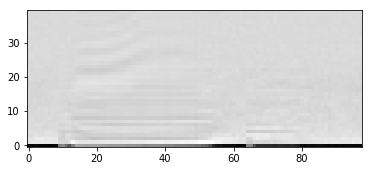

In [4]:
wav_fname = r"C:\tmp\speech_dataset\dog\00f0204f_nohash_1.wav"
mfcc = sess.run(mfcc_tensor, feed_dict={"wav_data:0": wav_fname})
plt.imshow(mfcc.T.squeeze(), origin='lower', cmap='gray')
plt.show()

## 2 - Load training set

In [5]:
with open('cnn_200_training.pickle', 'rb') as f:
    train = pickle.load(f)
train_x = train["input"]
train_y = train["out"]

## 3 - Load SOM

In [6]:
with open('som_with_cnn_200.pickle', 'rb') as f:
    dsom = pickle.load(f)

plotting result


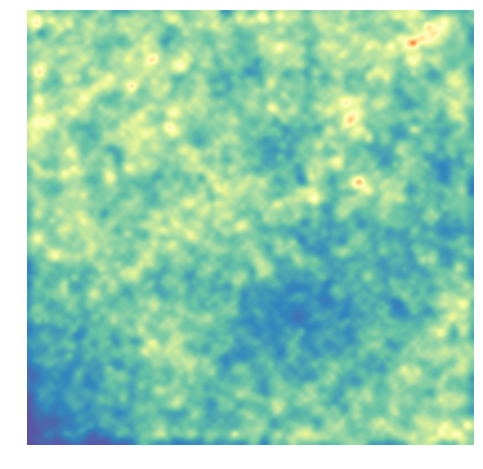

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
print("plotting result")
dsom._layers["som_0"].view_umatrix()

In [66]:
som = dsom._layers["som_0"]
print(train_x.shape)
dv = np.array(train_x[:10])
print(dv.shape)


(10000, 200)
(10, 200)


-11.899865 12.388756
None None
training
training 1 layer out of 1
-12.950595 16.13739


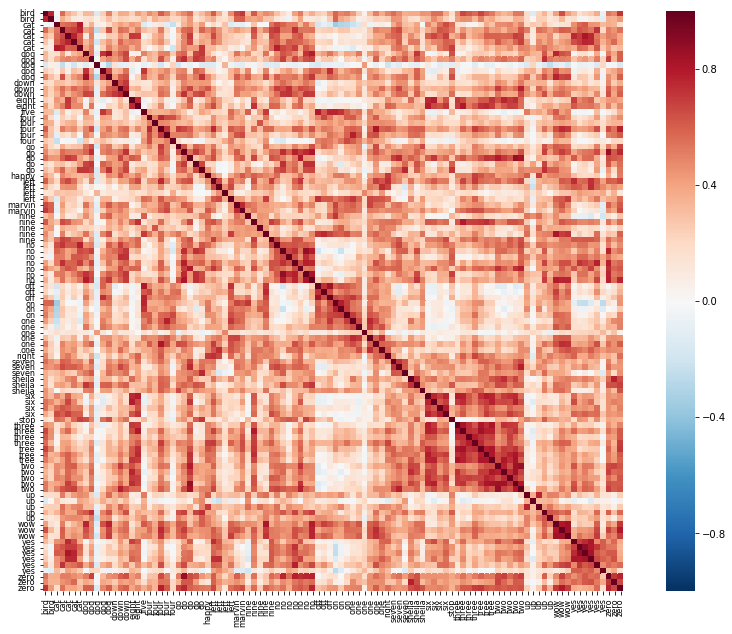

(100, 10000)


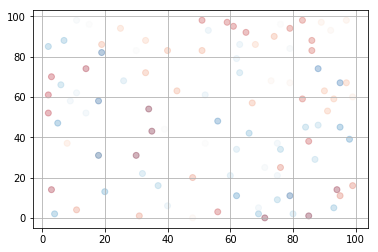

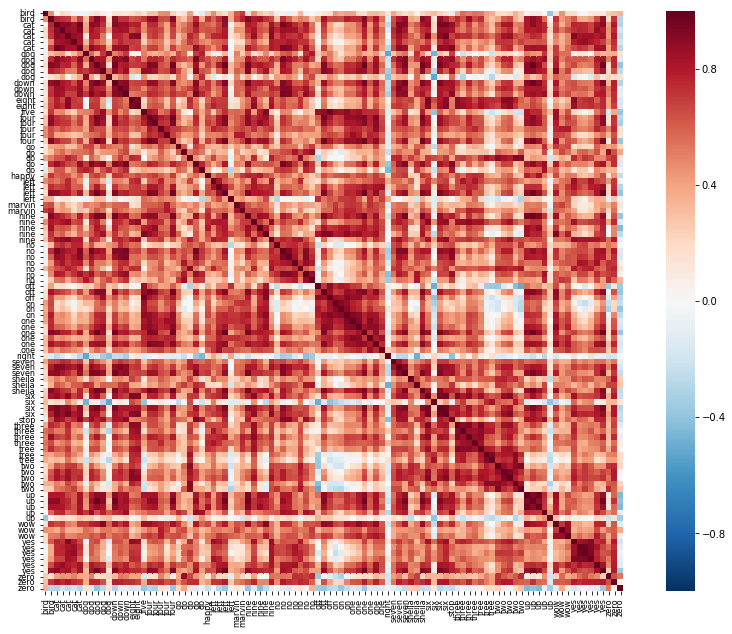

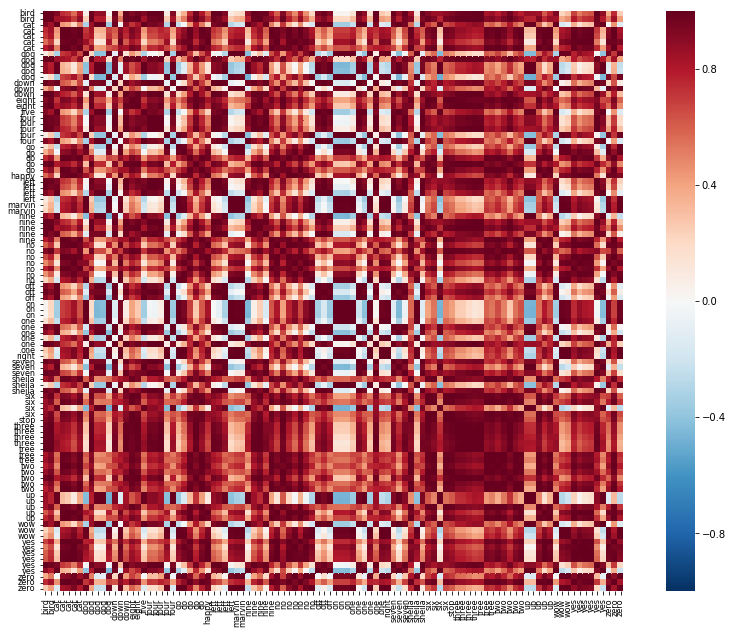

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [78]:
test_x = np.array(train_x[:100])
test_y = np.array(train_y[:100])

print(np.min(test_x), np.max(test_x))

dsom = ds.DeepSom()
dsom.add_layer(100, 100, 200)

som = dsom._layers["som_0"]
print(np.min(som.codebook), np.max(som.codebook))

print("training")
dsom.train(train_x[:200],epochs=30, verbose=1)

# som.update_data(test_x)
som = dsom._layers["som_0"]
print(np.min(som.codebook), np.max(som.codebook))
# som.train(epochs=50, radius0=50, scale0=0.1)


# labels=test_y
# cmap = plt.cm.get_cmap('RdBu')
# labels_set = set(labels)
# colors_list = [cmap(float(i) / len(labels_set)) for i in range(len(labels_set))]

# label_to_color = dict(zip(labels_set, colors_list))

# colors = []
# for i, l in enumerate(labels):
#     colors.append(label_to_color[l])
    
# som.view_umatrix(bestmatches=True, bestmatchcolors=colors, labels=labels)


p = test_y.argsort()
test_y_sorted = test_y[p]
test_x_sorted = test_x[p]
som.view_similarity_matrix(data=test_x_sorted, labels=test_y_sorted)


am = som.get_surface_state(data=test_x_sorted)
print(am.shape)
bmus = som.get_bmus(activation_map=am)
som.view_bmus(bmus, test_y_sorted, legend=True)
som.view_similarity_matrix(am, labels=test_y_sorted)
som.view_similarity_matrix(np.append(bmus, np.zeros((bmus.shape[0], 1)), axis=1), labels=test_y_sorted)


In [60]:
M = np.array([[.10, .3000], [.1, .50]])
print(M)
pd = 1. - pairwise_distances(M, metric="correlation")
print(pd)

[[0.1 0.3]
 [0.1 0.5]]
[[1. 1.]
 [1. 1.]]


In [20]:
som.cluster()

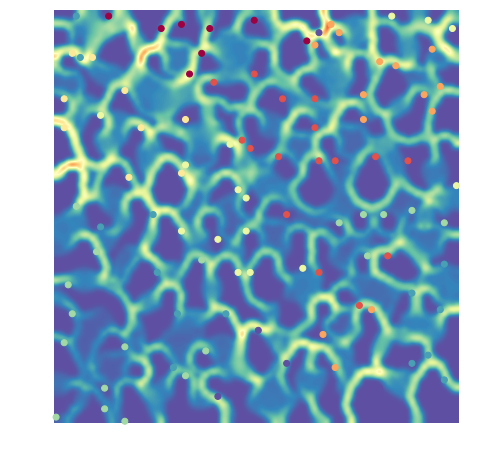

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [15]:
som.view_umatrix(bestmatches=True)

In [ ]:



sample_rate = 16000
clip_duration_ms = 1000
window_size_ms = 30.
window_stride_ms = 10.
dct_coefficient_count = 40

desired_samples = int(sample_rate * clip_duration_ms / 1000)
window_size_samples = int(sample_rate * window_size_ms / 1000)
window_stride_samples = int(sample_rate * window_stride_ms / 1000)
length_minus_window = (desired_samples - window_size_samples)
if length_minus_window < 0:
    spectrogram_length = 0
else:
    spectrogram_length = 1 + int(length_minus_window / window_stride_samples)
fingerprint_size = dct_coefficient_count * spectrogram_length

model_settings = {
      'desired_samples': desired_samples,
      'window_size_samples': window_size_samples,
      'window_stride_samples': window_stride_samples,
      'spectrogram_length': spectrogram_length,
      'dct_coefficient_count': dct_coefficient_count,
#      'fingerprint_size': fingerprint_size,
#       'label_count': label_count,
      'sample_rate': sample_rate,
  }
print(model_settings)